### HackOnData Challenge - Optimal Digital Map Placement

Data Source: 
City of Toronto Transportation Services (Pedestrian Projects team)

The city is planning to put 'map assets' (i.e. digital billboard maps) throughout the city indicating nearby attractions within a certain distance. A prototype unit has already been deployed near city hall in a test. The challenge is to use demographic/mapping data to determine the optimal location for new map assets to be rolled out.


Who are we targeting?
1. Local residents
2. Tourist

What age group are we targeting?



What is optimal location:

1. Location with large pedestrian volume
2. Location with many nearby attractions in a certain distance
3. Location with convenient public tranist to nearby attractions
4. Location where population density is high
5. Location where average income is high
6. Location where people w


What data do we have?
1. Major intersection pedestrian and vehicle volume
2. Mapping data for cultural facilities


What data do we need?
1. demographic data(population density, education, income, w/o children etc)
2. ...

### Baseline Model

Select intersection with largest pedestrain volume to place digital billboard

1. using pedestrain volume data, plot pedestrain volume data on map
2. select the top 50 intersection with largest pedestrain volume



### Condidering both pedestrain volume and number of nearby attractions in a certain distance

1. assign weights to nearby attractions according to their distance (in a certain diameter from the intersection). The further the distance, the lower the weights

2. Rank of attractions. Some attractions are more famous then others and attracts more people



### Using demographic data

Add more variables from demographic data to optimization model 



## Dataset

* Pedestrian and Vehicle Volume Data At major Intersections
  - `ped_vol_2012.csv`: pedestrian and vehicle volume data collected at some intersections in 2012 
  - `ped_vol_2013.csv`: pedestrian and vehicle volume data collected at some intersections in 2013
  - `ped_vol_2014.csv`: pedestrian and vehicle volume data collected at some intersections in 2014
  - `ped_vol_2015.csv`: pedestrian and vehicle volume data collected at some intersections in 2015
  - `signalizedTrafficPedestrianVolumes` - pedestrian and vehicle volume data collected at some intersections in from 1999 - 2012



* Cultural Facility Data
  The same data was provided in three formats
  - `MSFC_44_Wards_Complete_Final.csv`: It is list of cultural facilities in Toronto. The file consists of the name of the facility, address, ward information, ownership of facilities that are available on a rental basis for cultural events. The two accompanying documents `MSFC_Readme_1.csv` and `MSFC_Readme_2.csv` give detailed describe the contents of the file and the schema(columns) of the file. The `MSFC_44_Wards_Complete_Final.csv` only provides postal code, no coordinates for facility. 
  
  - `Make_space_for_culture_mtm3.zip`:  with shape files of MTM 3 coordinate system and facility file `MAKE_SPACE_FOR_CULTURE.dbf`, which contains coordinates for facilities. 
  - `Make_space_for_culture_wgs84.zip`: with shape files for WGS84 coordinate system and facility file `MAKE_SPACE_FOR_CULTURE_WGS84.dbf`, which contains coordinates for facilities.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import seaborn as sns
import folium
from folium import plugins
%matplotlib inline
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

In [2]:
ped_volume_2015 = pd.read_csv("./Data/ped_vol_2015.csv", header=None,
                             names=['PX', 'main', 'midblock_route', 'side1_route', 'side2_route', 'activation_date',
                                    'latitude', 'longitude', 'count_date', '8hr_vel_vol', '8hr_ped_vol'],
                             skiprows=1)

In [3]:
ped_volume_2015.head()

,PX,main,midblock_route,side1_route,side2_route,activation_date,latitude,longitude,count_date,8hr_vel_vol,8hr_ped_vol
0,8,JARVIS ST,NaN,DUNDAS ST E,NaN,21-Jun-1928,43.657052,-79.374531,4/13/2015,18207,7458
1,15,CHURCH ST,NaN,FRONT ST E,WELLINGTON ST E,24-Apr-1950,43.648513,-79.373834,4/20/2015,10467,7381
2,21,DUNDAS ST E,NaN,CHURCH ST,NaN,17-Dec-1952,43.656499,-79.377127,4/13/2015,13764,10302
3,31,YONGE ST,NaN,KING ST,NaN,03-Nov-1927,43.649162,-79.377904,1/22/2015,13527,33938
4,36,YONGE ST,NaN,DUNDAS ST,NaN,04-Apr-1927,43.656326,-79.380912,4/11/2015,10925,34615


In [4]:
ped_volume_2015.dtypes

PX                   int64
main                object
midblock_route      object
side1_route         object
side2_route         object
activation_date     object
latitude           float64
longitude          float64
count_date          object
8hr_vel_vol          int64
8hr_ped_vol          int64
dtype: object

In [5]:
ped_volume_2015.shape

(293, 11)

In [6]:
ped_volume_2014 = pd.read_csv("./Data/ped_vol_2014.csv",
                             names=['PX', 'main', 'midblock_route', 'side1_route', 'side2_route', 'activation_date',
                                    'latitude', 'longitude', 'count_date', '8hr_vel_vol', '8hr_ped_vol'],
                             skiprows=1)
ped_volume_2014.head()

,PX,main,midblock_route,side1_route,side2_route,activation_date,latitude,longitude,count_date,8hr_vel_vol,8hr_ped_vol
0,29,YONGE ST,NaN,FRONT ST,NaN,24-Aug-1928,43.646846,-79.376931,5/6/2014,10737,17522
1,30,YONGE ST,NaN,WELLINGTON ST,NaN,06-Jan-1964,43.647848,-79.377351,5/6/2014,13620,26656
2,33,YONGE ST,NaN,RICHMOND ST,NaN,03-Nov-1927,43.651697,-79.378965,5/6/2014,12388,24487
3,34,YONGE ST,NaN,QUEEN ST,NaN,03-Nov-1927,43.652421,-79.379276,5/5/2014,12035,26437
4,35,YONGE ST,NaN,SHUTER ST,NaN,12-Mar-1959,43.654066,-79.379957,5/10/2014,7830,21137


In [7]:
ped_volume_2014.dtypes

PX                   int64
main                object
midblock_route      object
side1_route         object
side2_route         object
activation_date     object
latitude           float64
longitude          float64
count_date          object
8hr_vel_vol          int64
8hr_ped_vol          int64
dtype: object

In [8]:
ped_volume_2014.shape

(298, 11)

In [9]:
ped_volume_2013 = pd.read_csv("./Data/ped_vol_2013.csv",
                             names=['PX', 'main', 'midblock_route', 'side1_route', 'side2_route', 'activation_date',
                                    'latitude', 'longitude', 'count_date', '8hr_vel_vol', '8hr_ped_vol'],
                             skiprows=1)
ped_volume_2013.head()

,PX,main,midblock_route,side1_route,side2_route,activation_date,latitude,longitude,count_date,8hr_vel_vol,8hr_ped_vol
0,13,MOUNT PLEASANT RD,NaN,CHARLES ST E,JARVIS ST,23-May-1950,43.669989,-79.379923,10/8/2013,15228,2269
1,23,CHURCH ST,NaN,CARLTON ST,NaN,17-Feb-1932,43.661871,-79.379335,6/26/2013,19901,9052
2,55,YONGE ST,NaN,LAWRENCE AVE,NaN,03-Jan-1941,43.725103,-79.402193,10/3/2013,29417,4196
3,81,UNIVERSITY AVE,NaN,DUNDAS ST W,NaN,28-Jun-1928,43.654812,-79.388484,8/14/2013,28831,18932
4,86,AVENUE RD,NaN,BLOOR ST W,NaN,21-Jul-1928,43.668685,-79.394119,5/27/2013,26039,14160


In [10]:
ped_volume_2013.dtypes

PX                   int64
main                object
midblock_route      object
side1_route         object
side2_route         object
activation_date     object
latitude           float64
longitude          float64
count_date          object
8hr_vel_vol          int64
8hr_ped_vol          int64
dtype: object

In [11]:
ped_volume_2013.shape

(295, 11)

In [12]:
ped_volume_2012 = pd.read_csv("./Data/ped_vol_2012.csv",
                             names=['PX', 'main', 'midblock_route', 'side1_route', 'side2_route', 'activation_date',
                                    'latitude', 'longitude', 'count_date', '8hr_vel_vol', '8hr_ped_vol'],
                             skiprows=1)
ped_volume_2012.head()

,PX,main,midblock_route,side1_route,side2_route,activation_date,latitude,longitude,count_date,8hr_vel_vol,8hr_ped_vol
0,4,JARVIS ST,NaN,ADELAIDE ST E,NaN,12-Sep-1958,43.651534,-79.372360,8/15/2012,19037,5679
1,14,BLOOR ST E,NaN,TED ROGERS WAY,NaN,28-Mar-1951,43.671577,-79.380520,5/31/2012,16991,7835
2,22,CHURCH ST,NaN,GERRARD ST E,NaN,18-Jul-1941,43.659858,-79.378522,9/5/2012,17164,14490
3,25,BLOOR ST E,NaN,CHURCH ST,NaN,19-Feb-1932,43.671022,-79.383123,5/30/2012,18894,26556
4,27,VICTORIA ST,NaN,RICHMOND ST E,NaN,03-Nov-1927,43.651952,-79.377756,7/10/2012,12770,6969


In [13]:
ped_volume_2012.dtypes

PX                   int64
main                object
midblock_route      object
side1_route         object
side2_route         object
activation_date     object
latitude           float64
longitude          float64
count_date          object
8hr_vel_vol          int64
8hr_ped_vol          int64
dtype: object

In [14]:
ped_volume_2012.shape

(468, 11)

In [15]:
# note that in the signalizedTrafficPedestrianVolumes.csv file, 
# the 8hr_vel_vol, 8hr_ped_vol, 24hr_vel_vol, and 24hr_ped_vol columns
# contains comma in the number. So you need to use the keyword parameter
# thousands ="," to correly read the table.
# otherwise those columns will be return as object(string) columns

ped_volume_all = pd.read_csv("./Data/signalizedTrafficPedestrianVolumes.csv",
                            names=['PX', 'main', 'midblock_route', 'side1_route', 'side2_route', 
                                   'activation_date','latitude', 'longitude', 'count_date',
                                   '8hr_vel_vol', '8hr_ped_vol', '24hr_ped_vol', '24hr_veh_vol'],
                             skiprows=1, thousands=",")
ped_volume_all.head()

,PX,main,midblock_route,side1_route,side2_route,activation_date,latitude,longitude,count_date,8hr_vel_vol,8hr_ped_vol,24hr_ped_vol,24hr_veh_vol
0,2,JARVIS ST,NaN,FRONT ST E,NaN,11/15/1948,43.649450,-79.371410,9/8/2011,17008,19335,34016,38670
1,3,KING ST E,NaN,JARVIS ST,NaN,8/23/1950,43.650461,-79.371924,9/7/2011,37719,17665,75438,35330
2,4,JARVIS ST,NaN,ADELAIDE ST E,NaN,9/12/1958,43.651534,-79.372360,6/16/2008,1991,19726,3982,39452
3,5,JARVIS ST,NaN,RICHMOND ST E,NaN,4/21/1962,43.652718,-79.372824,7/30/2009,2696,24842,5392,49684
4,6,JARVIS ST,NaN,QUEEN ST E,NaN,8/24/1928,43.653704,-79.373238,5/18/2011,3622,19772,7244,39544


In [16]:
ped_volume_all.dtypes

PX                   int64
main                object
midblock_route      object
side1_route         object
side2_route         object
activation_date     object
latitude           float64
longitude          float64
count_date          object
8hr_vel_vol          int64
8hr_ped_vol          int64
24hr_ped_vol         int64
24hr_veh_vol         int64
dtype: object

In [17]:
ped_volume_all.shape

(2209, 13)

In [18]:
ped_volume_2012.shape[0]+ped_volume_2013.shape[0]+ped_volume_2014.shape[0]+ped_volume_2015.shape[0]

1354

In [19]:
frames = [ped_volume_2012, ped_volume_2013, ped_volume_2014, ped_volume_2015]
ped_vol_2012_2015 = pd.concat(frames)
ped_vol_2012_2015.head()

,PX,main,midblock_route,side1_route,side2_route,activation_date,latitude,longitude,count_date,8hr_vel_vol,8hr_ped_vol
0,4,JARVIS ST,NaN,ADELAIDE ST E,NaN,12-Sep-1958,43.651534,-79.372360,8/15/2012,19037,5679
1,14,BLOOR ST E,NaN,TED ROGERS WAY,NaN,28-Mar-1951,43.671577,-79.380520,5/31/2012,16991,7835
2,22,CHURCH ST,NaN,GERRARD ST E,NaN,18-Jul-1941,43.659858,-79.378522,9/5/2012,17164,14490
3,25,BLOOR ST E,NaN,CHURCH ST,NaN,19-Feb-1932,43.671022,-79.383123,5/30/2012,18894,26556
4,27,VICTORIA ST,NaN,RICHMOND ST E,NaN,03-Nov-1927,43.651952,-79.377756,7/10/2012,12770,6969


In [20]:
ped_vol_2012_2015.count()

PX                 1354
main               1354
midblock_route       76
side1_route        1354
side2_route         418
activation_date    1354
latitude           1354
longitude          1354
count_date         1354
8hr_vel_vol        1354
8hr_ped_vol        1354
dtype: int64

In [21]:
ped_vol_mix = ped_volume_all.drop(['24hr_ped_vol', '24hr_veh_vol'], axis=1)

In [22]:
ped_vol_mix.head()

,PX,main,midblock_route,side1_route,side2_route,activation_date,latitude,longitude,count_date,8hr_vel_vol,8hr_ped_vol
0,2,JARVIS ST,NaN,FRONT ST E,NaN,11/15/1948,43.649450,-79.371410,9/8/2011,17008,19335
1,3,KING ST E,NaN,JARVIS ST,NaN,8/23/1950,43.650461,-79.371924,9/7/2011,37719,17665
2,4,JARVIS ST,NaN,ADELAIDE ST E,NaN,9/12/1958,43.651534,-79.372360,6/16/2008,1991,19726
3,5,JARVIS ST,NaN,RICHMOND ST E,NaN,4/21/1962,43.652718,-79.372824,7/30/2009,2696,24842
4,6,JARVIS ST,NaN,QUEEN ST E,NaN,8/24/1928,43.653704,-79.373238,5/18/2011,3622,19772


In [23]:
frames =[ped_vol_2012_2015, ped_vol_mix]
ped_vol_all = pd.concat(frames)
ped_vol_all.head()

,PX,main,midblock_route,side1_route,side2_route,activation_date,latitude,longitude,count_date,8hr_vel_vol,8hr_ped_vol
0,4,JARVIS ST,NaN,ADELAIDE ST E,NaN,12-Sep-1958,43.651534,-79.372360,8/15/2012,19037,5679
1,14,BLOOR ST E,NaN,TED ROGERS WAY,NaN,28-Mar-1951,43.671577,-79.380520,5/31/2012,16991,7835
2,22,CHURCH ST,NaN,GERRARD ST E,NaN,18-Jul-1941,43.659858,-79.378522,9/5/2012,17164,14490
3,25,BLOOR ST E,NaN,CHURCH ST,NaN,19-Feb-1932,43.671022,-79.383123,5/30/2012,18894,26556
4,27,VICTORIA ST,NaN,RICHMOND ST E,NaN,03-Nov-1927,43.651952,-79.377756,7/10/2012,12770,6969


In [24]:
ped_vol_all.dtypes

PX                   int64
main                object
midblock_route      object
side1_route         object
side2_route         object
activation_date     object
latitude           float64
longitude          float64
count_date          object
8hr_vel_vol          int64
8hr_ped_vol          int64
dtype: object

In [25]:
ped_vol_all.sort_values('PX')

,PX,main,midblock_route,side1_route,side2_route,activation_date,latitude,longitude,count_date,8hr_vel_vol,8hr_ped_vol
0,2,JARVIS ST,NaN,FRONT ST E,NaN,11/15/1948,43.649450,-79.371410,9/8/2011,17008,19335
1,3,KING ST E,NaN,JARVIS ST,NaN,8/23/1950,43.650461,-79.371924,9/7/2011,37719,17665
0,4,JARVIS ST,NaN,ADELAIDE ST E,NaN,12-Sep-1958,43.651534,-79.372360,8/15/2012,19037,5679
2,4,JARVIS ST,NaN,ADELAIDE ST E,NaN,9/12/1958,43.651534,-79.372360,6/16/2008,1991,19726
3,5,JARVIS ST,NaN,RICHMOND ST E,NaN,4/21/1962,43.652718,-79.372824,7/30/2009,2696,24842
4,6,JARVIS ST,NaN,QUEEN ST E,NaN,8/24/1928,43.653704,-79.373238,5/18/2011,3622,19772
5,7,JARVIS ST,NaN,SHUTER ST,NaN,11/18/1948,43.655357,-79.373862,5/24/2011,1979,17492
6,8,JARVIS ST,NaN,DUNDAS ST E,NaN,6/21/1928,43.657052,-79.374531,5/18/2011,5651,20116
0,8,JARVIS ST,NaN,DUNDAS ST E,NaN,21-Jun-1928,43.657052,-79.374531,4/13/2015,18207,7458
7,9,JARVIS ST,NaN,GERRARD ST E,NaN,7/14/1941,43.660432,-79.375854,5/18/2011,4284,19891


### Average pedestrian and vehicle voluem for intersection with multiple record

1. Create two data frames from `ped_vol_all` data frame.
2. first data frame colums `PX`, `main`, `midblock_route`, `side1_route`, `side2_route`, `latitude`, and `longitude`. Remove duplicates
3. second data frame columns `PX`, `8hr_vel_vol`, `8hr_ped_vol`
4. join the two data frame by `PX`

In [26]:
dscp_df = ped_vol_all[['PX', 'main', 'midblock_route', 'side1_route', 
                       'side2_route', 'latitude', 'longitude']]
dscp_df.sort_values('PX')

,PX,main,midblock_route,side1_route,side2_route,latitude,longitude
0,2,JARVIS ST,NaN,FRONT ST E,NaN,43.649450,-79.371410
1,3,KING ST E,NaN,JARVIS ST,NaN,43.650461,-79.371924
0,4,JARVIS ST,NaN,ADELAIDE ST E,NaN,43.651534,-79.372360
2,4,JARVIS ST,NaN,ADELAIDE ST E,NaN,43.651534,-79.372360
3,5,JARVIS ST,NaN,RICHMOND ST E,NaN,43.652718,-79.372824
4,6,JARVIS ST,NaN,QUEEN ST E,NaN,43.653704,-79.373238
5,7,JARVIS ST,NaN,SHUTER ST,NaN,43.655357,-79.373862
6,8,JARVIS ST,NaN,DUNDAS ST E,NaN,43.657052,-79.374531
0,8,JARVIS ST,NaN,DUNDAS ST E,NaN,43.657052,-79.374531
7,9,JARVIS ST,NaN,GERRARD ST E,NaN,43.660432,-79.375854


In [27]:
dscp_unique_df = dscp_df.drop_duplicates('PX')
dscp_unique_df.count() # 2256 rows

PX                2256
main              2256
midblock_route     172
side1_route       2256
side2_route        749
latitude          2256
longitude         2256
dtype: int64

In [28]:
ped_vel_vol_df = ped_vol_all[['PX', '8hr_vel_vol', '8hr_ped_vol']]
ped_vel_vol_df.sort_values('PX')

,PX,8hr_vel_vol,8hr_ped_vol
0,2,17008,19335
1,3,37719,17665
0,4,19037,5679
2,4,1991,19726
3,5,2696,24842
4,6,3622,19772
5,7,1979,17492
6,8,5651,20116
0,8,18207,7458
7,9,4284,19891


In [29]:
avg_ped_vel_df = ped_vel_vol_df.groupby('PX').mean()
avg_ped_vel_df  # 2256 rows

,8hr_vel_vol,8hr_ped_vol
PX,,
2,17008.0,19335.000000
3,37719.0,17665.000000
4,10514.0,12702.500000
5,2696.0,24842.000000
6,3622.0,19772.000000
7,1979.0,17492.000000
8,11929.0,13787.000000
9,4284.0,19891.000000
10,4189.0,21040.000000


In [30]:
avg_ped_vel_df.dtypes

8hr_vel_vol    float64
8hr_ped_vol    float64
dtype: object

### Join the two dataframes

In [31]:
volume_df = dscp_unique_df.join(avg_ped_vel_df, on='PX', how='inner')
volume_df # This will be the dataframe for our analysis

,PX,main,midblock_route,side1_route,side2_route,latitude,longitude,8hr_vel_vol,8hr_ped_vol
0,4,JARVIS ST,NaN,ADELAIDE ST E,NaN,43.651534,-79.372360,10514.000000,12702.500000
1,14,BLOOR ST E,NaN,TED ROGERS WAY,NaN,43.671577,-79.380520,10708.500000,11617.000000
2,22,CHURCH ST,NaN,GERRARD ST E,NaN,43.659858,-79.378522,11522.000000,16291.500000
3,25,BLOOR ST E,NaN,CHURCH ST,NaN,43.671022,-79.383123,20764.000000,23480.000000
4,27,VICTORIA ST,NaN,RICHMOND ST E,NaN,43.651952,-79.377756,9195.000000,9826.000000
5,31,YONGE ST,NaN,KING ST,NaN,43.649162,-79.377904,17091.000000,24051.333333
6,32,YONGE ST,NaN,ADELAIDE ST,NaN,43.650419,-79.378436,17540.500000,21387.000000
7,34,YONGE ST,NaN,QUEEN ST,NaN,43.652421,-79.379276,17584.000000,22005.666667
8,35,YONGE ST,NaN,SHUTER ST,NaN,43.654066,-79.379957,9091.000000,13155.666667
9,39,YONGE ST,NaN,WELLESLEY ST,NaN,43.664935,-79.384558,17296.000000,16999.500000


## Facility Data

Facility Data

#### Column name  (Description)
---
**ADD_NUM** = ADDRESS_NUMBER  (Street number)  
**LF_NAME** = LINEAR_NAME_FULL  (Street Name)  
**ADDRESS** = ADDRESS_FULL  (Full address)  
**POSTAL_CD** = POSTAL_CODE  (POSTAL CODE)  
**CITY** = CITY  
**X** = X  (Easting in MTM NAD27 3 degree Projection)  
**Y** = Y  (Northing in MTM NAD27 3 degree Projection)  
**LONGITUDE** = LONGITUDE  (LONGITUDE = Longitude in WGS84 Coordinate System)  
**LATITUDE** = LATITUDE  (Latitude in WGS84 Coordinate System)  
**FAC_NAM** = FACILITY_NAME  (FACILITY NAME)  
**STE_FLR_UN** = SUITE_FLOOR_UNIT  (SUITE FLOOR UNIT)  
**PERFRMANCE** = PERFORMANCE  (Spaces in which performing arts (dance, music, theatre, etc.) creation or presentation takes place)  
**EXHBVISARTT** = EXHIBITION_VISUAL_ARTS  (Spaces in which visual arts creation or presentation can take place, in addition to pure exhibition space.)  
**SCRN_BASED** = SCREEN_BASED  (Spaces for the production and presentation of multimedia screen-based arts including digital, )  
**LIBRARY** = LIBRARY  (Toronto Public Library facility with physical space for cultural activity)  
**MULTIPURP** = MULTIPURPOSE  (Spaces that are not purpose-built and can house a range of cultural activity across disciplines.)  
**HERITAGE** = HERITAGE  (Facilities where heritage activity takes place (historical societies, archives, community museums etc.)  
**OWNERSHIP** = OWNERSHIP  (OWNERSHIP)  
**OBJECTID** = OBJECTID  (Unique system identifier)  

In [32]:
# column nams for facility data frame
names = ['add_num', 'lf_name', 'address', 'postal_cd', 'city', 'x', 'y', 'longitude', 'latitude', 'fac_name',
        'ste_flr_un', 'performance', 'exhbvisart', 'scrn_based', 'library', 'multipurp', 'heritage', 'ownership', 'objectID']

In [33]:
facility_df = pd.read_csv('./Data/facilities/make_space_for_culture_wgs84/MAKE_SPACE_FOR_CULTURE_WGS84.csv',
                         names = names, skiprows =1)
facility_df

,add_num,lf_name,address,postal_cd,city,x,y,longitude,latitude,fac_name,ste_flr_un,performance,exhbvisart,scrn_based,library,multipurp,heritage,ownership,objectID
0,3465,Dundas St W,3465 Dundas St W,M6S 2S5,Toronto,305795.585,4835942.551,-79.487461,43.665434,Club Hispano,NaN,1,1,0,0,0,0,Owned by others,191
1,181,Glenlake Ave,181 Glenlake Ave,M6P 4B6,Toronto,307834.850,4835127.684,-79.462181,43.658093,Keele Community Centre,NaN,0,0,0,0,1,0,City Owned,194
2,288,Humberside Ave,288 Humberside Ave,M6P 1L5,Toronto,307268.847,4835411.316,-79.469196,43.660649,St. Johns West Toronto Anglican Church,NaN,1,0,0,0,1,0,Owned by others,195
3,238,Jane St,238 Jane St,M6S 3Z1,Toronto,305831.038,4834780.388,-79.487021,43.654964,Art Works Art School,NaN,0,1,0,0,0,0,Owned by others,196
4,95,Lavinia Ave,95 Lavinia Ave,M6S 3H9,Toronto,306568.733,4833967.983,-79.477882,43.647658,Swansea Memorial Library,NaN,0,0,0,1,0,0,City Owned,199
5,4066,Old Dundas St,4066 Old Dundas St,M6S 2R6,Toronto,304493.023,4835688.812,-79.503611,43.663150,Lambton House,NaN,0,1,1,0,1,1,City Owned,200
6,396,Pacific Ave,396 Pacific Ave,M6P 2R1,Toronto,307304.397,4835926.822,-79.468753,43.665289,The Junction Business Improvement Area (BIA),Suite 205,1,0,0,0,0,0,Owned by others,201
7,280,Quebec Ave,280 Quebec Ave,M6P 2V3,Toronto,307151.945,4835333.803,-79.470646,43.659951,Humberside Collegiate Institute (Lismer Hall),NaN,1,1,1,0,1,0,Owned by others,202
8,15,Waller Ave,15 Waller Ave,M6S 4Z9,Toronto,306630.380,4833574.020,-79.477119,43.644112,Swansea Community Recreation Centre,NaN,1,0,0,0,1,0,City Owned,204
9,207,Windermere Ave,207 Windermere Ave,M6S 3J9,Toronto,306632.849,4833502.245,-79.477088,43.643466,Swansea Public School,NaN,1,1,1,0,1,0,Owned by others,205


In [51]:
facility_df.dtypes

add_num         object
lf_name         object
address         object
postal_cd       object
city            object
x              float64
y              float64
longitude      float64
latitude       float64
fac_name        object
ste_flr_un      object
performance      int64
exhbvisart       int64
scrn_based       int64
library          int64
multipurp        int64
heritage         int64
ownership       object
objectID         int64
dtype: object

## Visualization

### Intersection

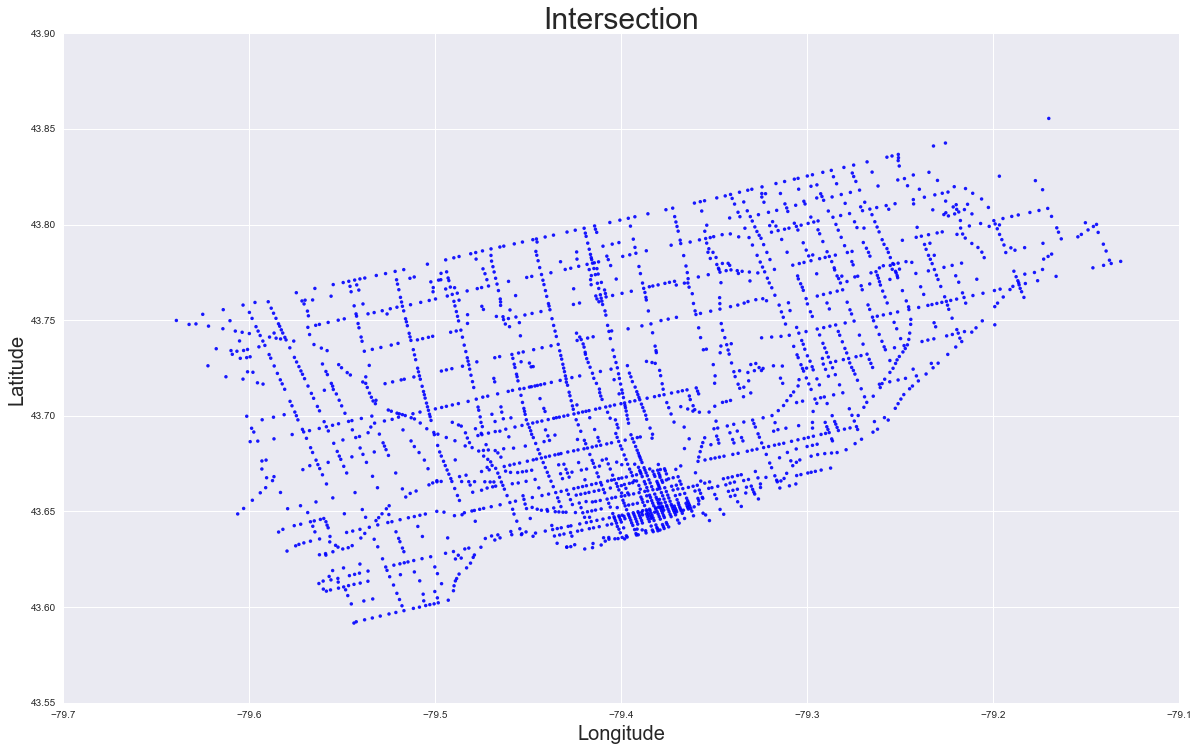

In [111]:
fig, ax = plt.subplots(figsize=[20, 12])
intersection_scatter = ax.scatter(volume_df['longitude'], volume_df['latitude'], c='b', edgecolor='None', alpha=0.9, s=12)
ax.set_title('Intersection', fontsize = 30)
ax.set_xlabel('Longitude', fontsize=20)
ax.set_ylabel('Latitude', fontsize =20)
#ax.legend([intersection_scatter], ['Intersection'], loc='upper right', fontsize = 20)
plt.show()

In [56]:
toronto_map = folium.Map(location = [43.6532, -79.3832])
toronto_map.save('toronto.html')

In [57]:
toronto_map

In [62]:
folium.Marker([43.64344628, -79.37900385], popup='Air Canada Centre').add_to(toronto_map)
toronto_map.save('Air_Canada_Centre.html')

In [63]:
toronto_map

## Facility Map

### Facility Distribution

It is no suprise that the facilities are condensed in downtown area. 

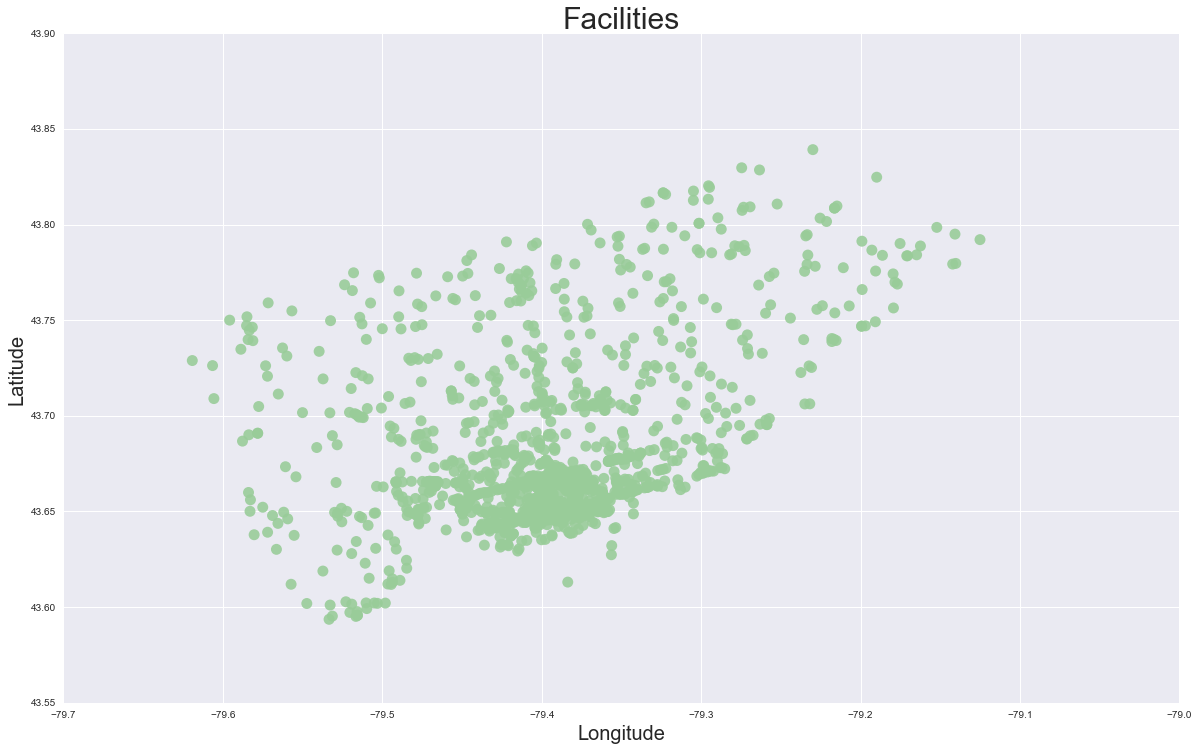

In [112]:
fig, ax = plt.subplots(figsize=[20, 12])
facility_scatter = ax.scatter(facility_df['longitude'], facility_df['latitude'], c='#99cc99', edgecolor='None', alpha=0.9, s=120)
ax.set_title('Facilities', fontsize = 30)
ax.set_xlabel('Longitude', fontsize=20)
ax.set_ylabel('Latitude', fontsize =20)
#ax.legend([facility_scatter], ['Facility'], loc='upper right', fontsize = 20)
plt.show()

### Facility Distribution on Map

In [127]:
facility_map = folium.Map(location = [43.6532, -79.3832])
facility_map.save('toronto.html')
marker_cluster = folium.MarkerCluster().add_to(facility_map)
for index, row in facility_df.iterrows():
    folium.Marker([row["latitude"],row["longitude"]] ).add_to(marker_cluster)
facility_map.save('facilities.html')
facility_map

## Intersection Map

In [73]:
ist_map = folium.Map(location = [43.6532, -79.3832])
ist_map.save('intersect.html')
marker_cluster_ist = folium.MarkerCluster().add_to(ist_map)
for index, row in volume_df.iterrows():
    folium.Marker([row["latitude"],row["longitude"]] ).add_to(marker_cluster_ist)
ist_map.save('intersection.html')
ist_map

##  Clustering Facilities Based on Spatial Data

We will use [DBSCAN](http://scikit-learn.org/stable/modules/clustering.html#dbscan) algorithm in `scikit-learn` for clustering. DBSCAN is base on the paper:

* “A Density-Based Algorithm for Discovering Clusters in Large Spatial Databases with Noise” Ester, M., H. P. Kriegel, J. Sander, and X. Xu, In Proceedings of the 2nd International Conference on Knowledge Discovery and Data Mining, Portland, OR, AAAI Press, pp. 226–231. 1996

So this algorithm is aimed for spatial data, which is a good fit for our case.

The following is a description of DBSCAN algorithm from sklearn:

>The DBSCAN algorithm views clusters as areas of high density separated by areas of low density. Due to this rather generic view, clusters found by DBSCAN can be any shape, as opposed to k-means which assumes that clusters are convex shaped. The central component to the DBSCAN is the concept of core samples, which are samples that are in areas of high density. A cluster is therefore a set of core samples, each close to each other (measured by some distance measure) and a set of non-core samples that are close to a core sample (but are not themselves core samples). There are two parameters to the algorithm, `min_samples` and `eps`, which define formally what we mean when we say dense. Higher `min_samples` or lower `eps` indicate higher density necessary to form a cluster.

DBSCAN algorithm clusters dataset based on two parameters:

 * **eps** - The max distance between neighbour points to be considerted in a cluster

 *  **min_samples** - the minimum cluster size. If it is set to 1, it means every data point will be assigned to either a cluster or form its own cluster of 1 data point. If `min_sample` is set to be larger than one, then cluster with size less than min_sample will be considered as noise.

The scikit-learn DBSCAN haversine distance metric requires data in the form of [latitude, longitude] and both inputs and outputs are in units of radians.

**Reference**  
[Clustering to Reduce Spatial Data Set Size](http://geoffboeing.com/2014/08/clustering-to-reduce-spatial-data-set-size/)


### Choose Parameters for DBSCAN clustering algorithm

Since in our facility dataset, we need to consider all facilities, we don't want any of them to be classified as noise, so we set `min_samples`=1. 

Now our clustering will depend on a proper `esp` value.

Let's try esp = 1.5, 1.0, 0.7 (km)

Note esp need to be converted to radians for use by harversine

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
import time

In [113]:
# define the number of kilometers in one radiation
# we will use it to convert esp from km to radiation
kms_per_radian = 6371.0088

### esp = 1.5

In [114]:
# converted esp to radians for use by haversine
epsilon = 1.5/ kms_per_radian

# represent points consistently as (lat, lon)
coords = facility_df.as_matrix(columns=['latitude', 'longitude'])

start_time = time.time()
db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_

# get the number of clusters
num_clusters = len(set(cluster_labels))

# print the outcome
message = 'Clustered {:,} points down to {:,} clusters, for {:.1f}% compression in {:,.2f} seconds'
print(message.format(len(facility_df), num_clusters, 100*(1 - float(num_clusters) / len(facility_df)), time.time()-start_time))
print('Silhouette coefficient: {:0.03f}'.format(metrics.silhouette_score(coords, cluster_labels)))

# turn the clusters in to a pandas series, where each element is a cluster of points
clusters = pd.Series([coords[cluster_labels==n] for n in range(num_clusters)])

def get_centroid(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    return centroid
centroids = clusters.map(get_centroid)

# unzip the list of centroid points (lat, lon) tuples into separate lat and lon lists
lats, lons = zip(*centroids)

# from these lats/lons create a new df of one representative point for each cluster
centroids_df = pd.DataFrame({'lon':lons, 'lat':lats})

Clustered 1,397 points down to 20 clusters, for 98.6% compression in 0.23 seconds
Silhouette coefficient: -0.165


In [115]:
centroids_df

,lat,lon
0,43.677642,-79.398145
1,43.645880,-79.571181
2,43.746781,-79.581313
3,43.792897,-79.225278
4,43.727578,-79.612831
5,43.766111,-79.201257
6,43.689671,-79.581946
7,43.613089,-79.383681
8,43.709011,-79.605642
9,43.721643,-79.568410


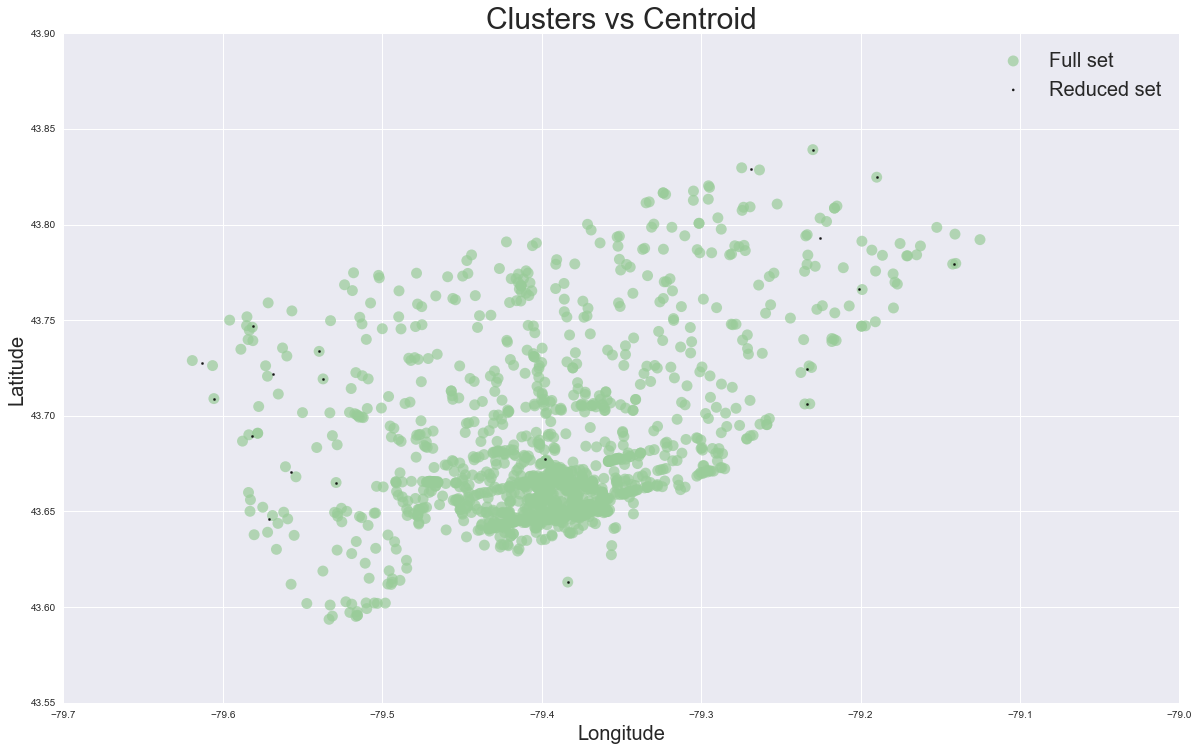

In [116]:
# plot the centroids points vs the original full set
fig, ax = plt.subplots(figsize=[20, 12])
facility_scatter = ax.scatter(facility_df['longitude'], facility_df['latitude'], c='#99cc99', edgecolor='None', alpha=0.7, s=120)
centroid_scatter = ax.scatter(centroids_df['lon'], centroids_df['lat'], c='k', alpha=0.9, s=5)
ax.set_title('Clusters vs Centroid', fontsize = 30)
ax.set_xlabel('Longitude', fontsize=20)
ax.set_ylabel('Latitude', fontsize = 20)
ax.legend([facility_scatter, centroid_scatter], ['Full set', 'Reduced set'], loc='upper right', fontsize = 20)
plt.show()

If we set esp=1.5 km, we get 20 Clusters. The number of cluster is too small

### esp = 1.0

In [117]:
# converted esp to radians for use by haversine
epsilon = 1.0/ kms_per_radian

# represent points consistently as (lat, lon)
coords = facility_df.as_matrix(columns=['latitude', 'longitude'])

start_time = time.time()
db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_

# get the number of clusters
num_clusters = len(set(cluster_labels))

# print the outcome
message = 'Clustered {:,} points down to {:,} clusters, for {:.1f}% compression in {:,.2f} seconds'
print(message.format(len(facility_df), num_clusters, 100*(1 - float(num_clusters) / len(facility_df)), time.time()-start_time))
print('Silhouette coefficient: {:0.03f}'.format(metrics.silhouette_score(coords, cluster_labels)))

# turn the clusters in to a pandas series, where each element is a cluster of points
clusters = pd.Series([coords[cluster_labels==n] for n in range(num_clusters)])

def get_centroid(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    return centroid
centroids = clusters.map(get_centroid)

# unzip the list of centroid points (lat, lon) tuples into separate lat and lon lists
lats, lons = zip(*centroids)

# from these lats/lons create a new df of one representative point for each cluster
centroids_df = pd.DataFrame({'lon':lons, 'lat':lats})

Clustered 1,397 points down to 93 clusters, for 93.3% compression in 0.11 seconds
Silhouette coefficient: -0.028


In [118]:
centroids_df

,lat,lon
0,43.666754,-79.391953
1,43.760041,-79.465894
2,43.648282,-79.573246
3,43.621883,-79.493054
4,43.758082,-79.380396
5,43.702657,-79.508903
6,43.740682,-79.273427
7,43.767326,-79.323671
8,43.768135,-79.413347
9,43.719285,-79.514376


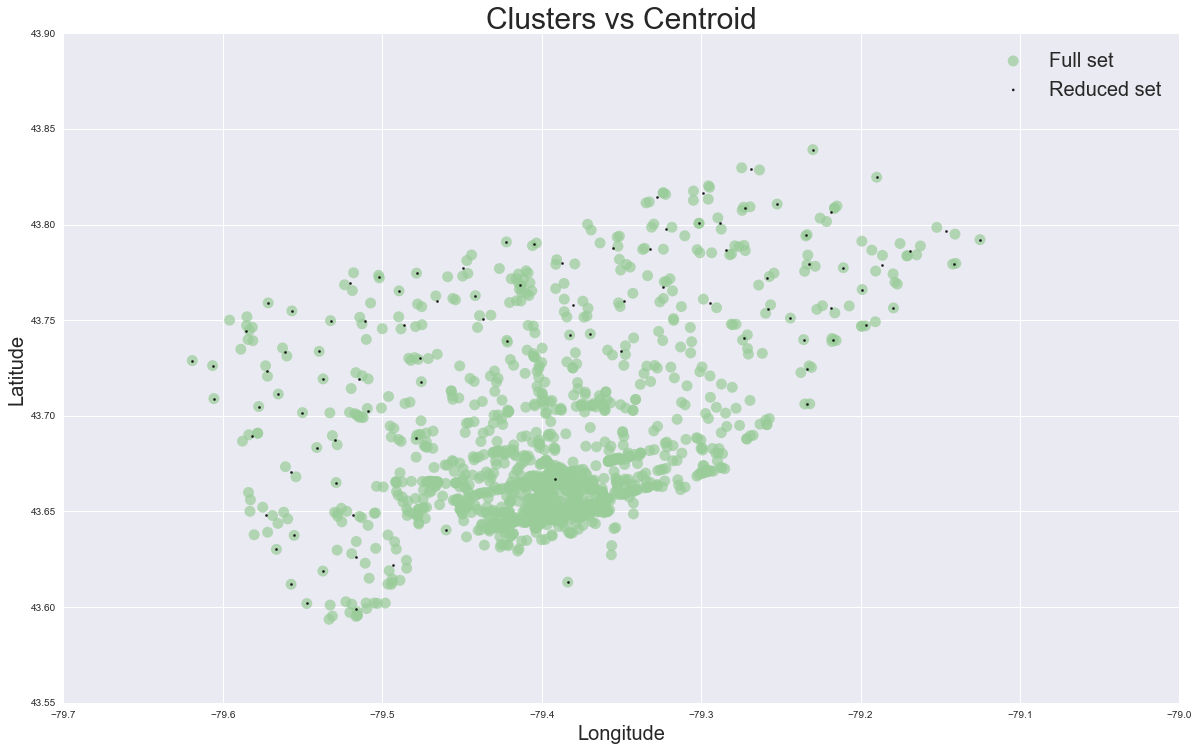

In [119]:
# plot the centroids points vs the original full set
fig, ax = plt.subplots(figsize=[20, 12])
facility_scatter = ax.scatter(facility_df['longitude'], facility_df['latitude'], c='#99cc99', edgecolor='None', alpha=0.7, s=120)
centroid_scatter = ax.scatter(centroids_df['lon'], centroids_df['lat'], c='k', alpha=0.9, s=5)
ax.set_title('Clusters vs Centroid', fontsize = 30)
ax.set_xlabel('Longitude', fontsize=20)
ax.set_ylabel('Latitude', fontsize = 20)
ax.legend([facility_scatter, centroid_scatter], ['Full set', 'Reduced set'], loc='upper right', fontsize = 20)
plt.show()

With esp = 1.0, we get a 93 clusters, it is a realitve good result. But the downtown cluster is very big, we need conduct further clustering for the downtown cluster. 

### esp = 0.7

In [120]:
# converted esp to radians for use by haversine
epsilon = 0.7/ kms_per_radian

# represent points consistently as (lat, lon)
coords = facility_df.as_matrix(columns=['latitude', 'longitude'])

start_time = time.time()
db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_

# get the number of clusters
num_clusters = len(set(cluster_labels))

# print the outcome
message = 'Clustered {:,} points down to {:,} clusters, for {:.1f}% compression in {:,.2f} seconds'
print(message.format(len(facility_df), num_clusters, 100*(1 - float(num_clusters) / len(facility_df)), time.time()-start_time))
print('Silhouette coefficient: {:0.03f}'.format(metrics.silhouette_score(coords, cluster_labels)))

# turn the clusters in to a pandas series, where each element is a cluster of points
clusters = pd.Series([coords[cluster_labels==n] for n in range(num_clusters)])

def get_centroid(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    return centroid
centroids = clusters.map(get_centroid)

# unzip the list of centroid points (lat, lon) tuples into separate lat and lon lists
lats, lons = zip(*centroids)

# from these lats/lons create a new df of one representative point for each cluster
centroids_df = pd.DataFrame({'lon':lons, 'lat':lats})

Clustered 1,397 points down to 185 clusters, for 86.8% compression in 0.04 seconds
Silhouette coefficient: 0.004


In [121]:
centroids_df

,lat,lon
0,43.658554,-79.399235
1,43.632408,-79.435979
2,43.695167,-79.445882
3,43.718765,-79.443661
4,43.710901,-79.455493
5,43.706631,-79.439653
6,43.757745,-79.476572
7,43.650728,-79.572515
8,43.614129,-79.493830
9,43.754982,-79.372579


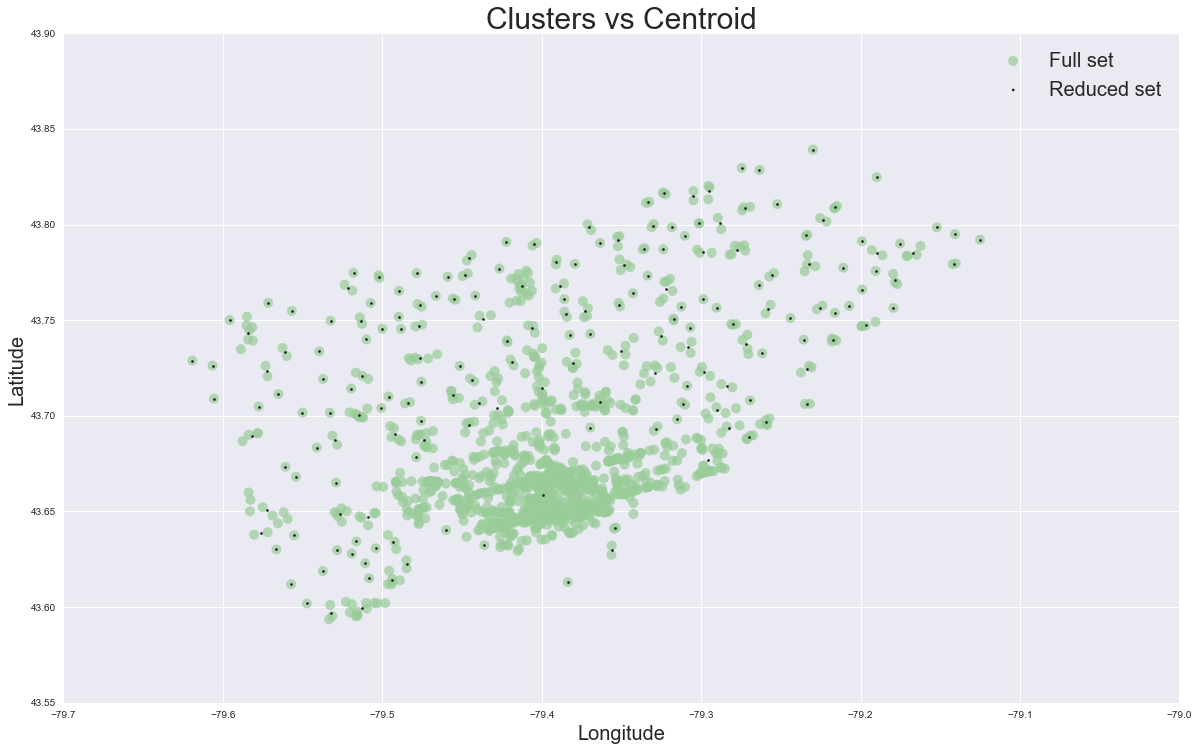

In [126]:
# plot the centroids points vs the original full set
fig, ax = plt.subplots(figsize=[20, 12])
facility_scatter = ax.scatter(facility_df['longitude'], facility_df['latitude'], c='#99cc99', edgecolor='None', alpha=0.7, s=100)
centroid_scatter = ax.scatter(centroids_df['lon'], centroids_df['lat'], c='k', alpha=0.9, s=5)
ax.set_title('Clusters vs Centroid', fontsize = 30)
ax.set_xlabel('Longitude', fontsize=20)
ax.set_ylabel('Latitude', fontsize = 20)
ax.legend([facility_scatter, centroid_scatter], ['Full set', 'Reduced set'], loc='upper right', fontsize = 20)
plt.show()

Now we have 185 clusters, but most clusters outside down town area are single facility cluster. which means this might not be a good choice.

## Further Clustering for the downtown cluster

1. Select all the facilities in the downtown cluster
2. apply DBSCAN clustering algorithm again with small `esp`

try esp = 0.5, 0.3 (km)

or try kmeans clustering for downtown cluster

## Plot bubble map plot of pedestrian volum on map